# ML Pipeline Preparation
Follow the instructions below to help you create your ML pipeline.
###  Import libraries and load data from database.
- Import Python libraries
- Load dataset from database with [`read_sql_table`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_sql_table.html)
- Define feature and target variables X and Y

In [67]:
# import libraries
import nltk
nltk.download('punkt')
nltk.download('wordnet')
#nltk.download()
import pandas as pd
from sqlalchemy import create_engine
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import re
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn import multioutput
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
nltk.download('stopwords')
from custom_transformer import StartingVerbExtractor
from sklearn.metrics import fbeta_score, make_scorer
import pickle

import matplotlib.pyplot as plt
%matplotlib inline

[nltk_data] Downloading package punkt to
[nltk_data]     D:\Users\Kusainov\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     D:\Users\Kusainov\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     D:\Users\Kusainov\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### 1. Define functions for measuring model predictions (f1, precision, recall) for each class within multi-class prediction 

In [52]:
def f1_pre_acc_evaluation (y_true, y_pred): 
    """A function that measures mean of f1, precision, recall for each class within multi-class prediction 
       Returns a dataframe with columns: 
       f1-score (average for all possible values of specific class)
       precision (average for all possible values of specific class)
       recall (average for all possible values of specific class)
       kindly keep in mind that some classes might be imbalanced and average values may mislead. 
    """
    #instantiating a dataframe
    report = pd.DataFrame ()
    
    for col in y_true.columns:
        #returning dictionary from classification report
        class_dict = classification_report (output_dict = True, y_true = y_true.loc [:,col], y_pred = y_pred.loc [:,col])
    
        #converting from dictionary to dataframe
        eval_df = pd.DataFrame (pd.DataFrame.from_dict (class_dict))
        
       # print (eval_df)
        
        #dropping unnecessary columns
        eval_df.drop(['micro avg', 'macro avg', 'weighted avg'], axis =1, inplace = True)
        
        #dropping unnecessary row "support"
        eval_df.drop(index = 'support', inplace = True)
        
        #calculating mean values
        av_eval_df = pd.DataFrame (eval_df.transpose ().mean ())
        
        #transposing columns to rows and vice versa 
        av_eval_df = av_eval_df.transpose ()
    
        #appending result to report df
        report = report.append (av_eval_df, ignore_index = True)    
    
    #renaming indexes for convinience
    report.index = y_true.columns
    
    return report

def f1_scorer_eval (y_true, y_pred): 
    """A function that measures mean of F1 for all classes 
       Returns an average value of F1 for sake of evaluation whether model predicts better or worse in GridSearchCV 
    """
    #converting y_pred from np.array to pd.dataframe
    #keep in mind that y_pred should a pd.dataframe rather than np.array
    y_pred = pd.DataFrame (y_pred, columns = y_true.columns)
    
    
    #instantiating a dataframe
    report = pd.DataFrame ()
    
    for col in y_true.columns:
        #returning dictionary from classification report
        class_dict = classification_report (output_dict = True, y_true = y_true.loc [:,col], y_pred = y_pred.loc [:,col])
    
        #converting from dictionary to dataframe
        eval_df = pd.DataFrame (pd.DataFrame.from_dict (class_dict))
        
        #dropping unnecessary columns
        eval_df.drop(['micro avg', 'macro avg', 'weighted avg'], axis =1, inplace = True)
        
        #dropping unnecessary row "support"
        eval_df.drop(index = 'support', inplace = True)
        
        #calculating mean values
        av_eval_df = pd.DataFrame (eval_df.transpose ().mean ())
        
        #transposing columns to rows and vice versa 
        av_eval_df = av_eval_df.transpose ()
    
        #appending result to report df
        report = report.append (av_eval_df, ignore_index = True)    
    
    #returining mean value for all classes. since it's used for GridSearch we may use mean
    #as the overall value of F1 should grow. 
    return report ['f1-score'].mean () 


### 2. A tokenization function to process text data

In [3]:
def tokenize(text):
    """Tokenization function. Receives as input raw text which afterwards normalized, stop words removed, stemmed and lemmatized.
    Returns tokenized text"""
    
    # Normalize text
    text = re.sub(r"[^a-zA-Z0-9]", " ", text.lower())
    
    stop_words = stopwords.words("english")
    
    #tokenize
    words = word_tokenize (text)
    
    #stemming
    stemmed = [PorterStemmer().stem(w) for w in words]
    
    #lemmatizing
    words_lemmed = [WordNetLemmatizer().lemmatize(w) for w in stemmed if w not in stop_words]
   
    return words_lemmed

### 3. Loading data

In [4]:
# load data from database
engine = create_engine('sqlite:///DisasterResponse.db')
df = pd.read_sql ('SELECT * FROM MessagesCategories', engine)
#display (df.head (n=10))
X = df ['message']
y = df.iloc[:,4:]
display (y.head (n=3))

,related,request,offer,aid_related,medical_help,medical_products,search_and_rescue,security,military,child_alone,...,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,1,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


D:\Users\Kusainov\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2963: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  exec(code_obj, self.user_global_ns, self.user_ns)


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000000000CBE9518>,
      dtype=object)

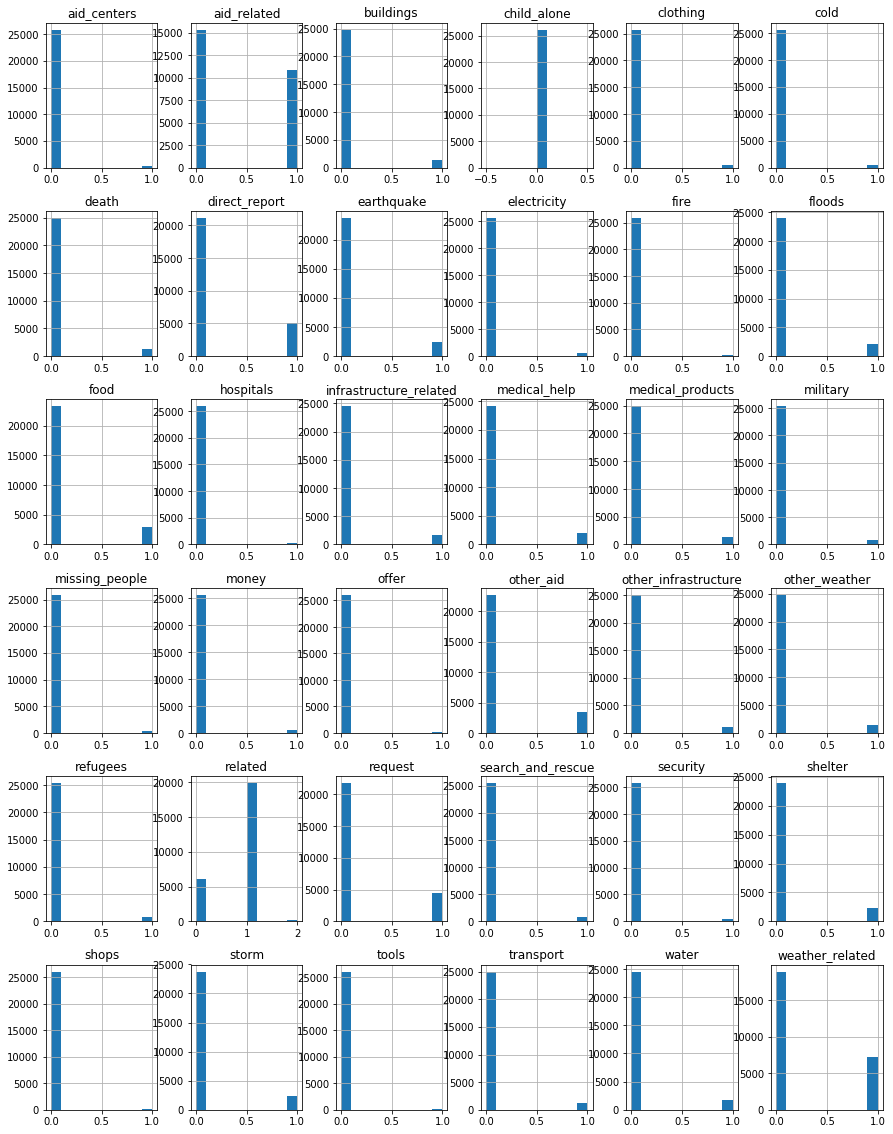

In [5]:
#let's take a look to the possible values distribution within classes

#making size of figure bigger
fig = plt.figure(figsize = (15,20))
ax = fig.gca()
y.hist(ax = ax)


##### As can be seen from the above histogram vast majority of classes are imbalanced. 

### 4. Build a machine learning pipeline
This machine pipeline should take in the `message` column as input and output classification results on the other 36 categories in the dataset. You may find the [MultiOutputClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.multioutput.MultiOutputClassifier.html) helpful for predicting multiple target variables.

In [6]:
#setting pipeline
pipeline = Pipeline([
        ('vect', CountVectorizer(tokenizer=tokenize)),
        ('tfidf', TfidfTransformer()),
#        ('clf', multioutput.MultiOutputClassifier (RandomForestClassifier(), n_jobs = 35))
        ('clf', multioutput.MultiOutputClassifier (RandomForestClassifier()))
        ])

### 5. Train pipeline
- Split data into train and test sets
- Train pipeline

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 22)

In [8]:
# train classifier
pipeline.fit(X_train, y_train)

D:\Users\Kusainov\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
D:\Users\Kusainov\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
D:\Users\Kusainov\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
D:\Users\Kusainov\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 t

D:\Users\Kusainov\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
D:\Users\Kusainov\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
D:\Users\Kusainov\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
D:\Users\Kusainov\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 t

Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip..._score=False, random_state=None, verbose=0,
            warm_start=False),
           n_jobs=None))])

### 6. Test your model
Report the f1 score, precision and recall for each output category of the dataset. You can do this by iterating through the columns and calling sklearn's `classification_report` on each.

In [9]:
y_pred = pipeline.predict (X_test)
#converting to dataframe
y_pred = pd.DataFrame (y_pred, columns = y_test.columns)

In [14]:
report = f1_pre_acc_evaluation (y_test, y_pred)

D:\Users\Kusainov\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### 7. Improve your model
Use grid search to find better parameters. 

In [53]:
# fbeta_score scoring object using make_scorer()
scorer = make_scorer (f1_scorer_eval)

parameters = { 'vect__max_df': (0.75, 1.0),
             #  'vect__stop_words': ('english', None),
                'clf__estimator__n_estimators': [10, 20],
                'clf__estimator__min_samples_split': [2, 5]
              }

cv = GridSearchCV (pipeline, param_grid= parameters, scoring = scorer, verbose =7 )

In [54]:
model = cv

In [55]:
model.fit(X_train, y_train)

D:\Users\Kusainov\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 8 candidates, totalling 24 fits
[CV] clf__estimator__min_samples_split=2, clf__estimator__n_estimators=10, vect__max_df=0.75 


D:\Users\Kusainov\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  clf__estimator__min_samples_split=2, clf__estimator__n_estimators=10, vect__max_df=0.75, score=0.6028828147515529, total= 1.3min
[CV] clf__estimator__min_samples_split=2, clf__estimator__n_estimators=10, vect__max_df=0.75 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.9min remaining:    0.0s
D:\Users\Kusainov\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  clf__estimator__min_samples_split=2, clf__estimator__n_estimators=10, vect__max_df=0.75, score=0.6039173425780062, total= 1.2min
[CV] clf__estimator__min_samples_split=2, clf__estimator__n_estimators=10, vect__max_df=0.75 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  3.6min remaining:    0.0s
D:\Users\Kusainov\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  clf__estimator__min_samples_split=2, clf__estimator__n_estimators=10, vect__max_df=0.75, score=0.606400326894084, total= 1.3min
[CV] clf__estimator__min_samples_split=2, clf__estimator__n_estimators=10, vect__max_df=1.0 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  5.7min remaining:    0.0s
D:\Users\Kusainov\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  clf__estimator__min_samples_split=2, clf__estimator__n_estimators=10, vect__max_df=1.0, score=0.5983979974248924, total= 1.5min
[CV] clf__estimator__min_samples_split=2, clf__estimator__n_estimators=10, vect__max_df=1.0 


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  7.8min remaining:    0.0s
D:\Users\Kusainov\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  clf__estimator__min_samples_split=2, clf__estimator__n_estimators=10, vect__max_df=1.0, score=0.6011713180699771, total= 1.2min
[CV] clf__estimator__min_samples_split=2, clf__estimator__n_estimators=10, vect__max_df=1.0 


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  9.6min remaining:    0.0s
D:\Users\Kusainov\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  clf__estimator__min_samples_split=2, clf__estimator__n_estimators=10, vect__max_df=1.0, score=0.6039959485842962, total= 1.2min
[CV] clf__estimator__min_samples_split=2, clf__estimator__n_estimators=20, vect__max_df=0.75 


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed: 11.4min remaining:    0.0s
D:\Users\Kusainov\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  clf__estimator__min_samples_split=2, clf__estimator__n_estimators=20, vect__max_df=0.75, score=0.6038790520697271, total= 1.8min
[CV] clf__estimator__min_samples_split=2, clf__estimator__n_estimators=20, vect__max_df=0.75 


D:\Users\Kusainov\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  clf__estimator__min_samples_split=2, clf__estimator__n_estimators=20, vect__max_df=0.75, score=0.605407541805183, total= 1.8min
[CV] clf__estimator__min_samples_split=2, clf__estimator__n_estimators=20, vect__max_df=0.75 


D:\Users\Kusainov\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  clf__estimator__min_samples_split=2, clf__estimator__n_estimators=20, vect__max_df=0.75, score=0.6066913257141384, total= 1.8min
[CV] clf__estimator__min_samples_split=2, clf__estimator__n_estimators=20, vect__max_df=1.0 


D:\Users\Kusainov\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  clf__estimator__min_samples_split=2, clf__estimator__n_estimators=20, vect__max_df=1.0, score=0.6049526676967678, total= 1.8min
[CV] clf__estimator__min_samples_split=2, clf__estimator__n_estimators=20, vect__max_df=1.0 


D:\Users\Kusainov\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  clf__estimator__min_samples_split=2, clf__estimator__n_estimators=20, vect__max_df=1.0, score=0.6072444393408222, total= 1.8min
[CV] clf__estimator__min_samples_split=2, clf__estimator__n_estimators=20, vect__max_df=1.0 


D:\Users\Kusainov\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  clf__estimator__min_samples_split=2, clf__estimator__n_estimators=20, vect__max_df=1.0, score=0.6068568158438631, total= 1.9min
[CV] clf__estimator__min_samples_split=5, clf__estimator__n_estimators=10, vect__max_df=0.75 


D:\Users\Kusainov\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  clf__estimator__min_samples_split=5, clf__estimator__n_estimators=10, vect__max_df=0.75, score=0.6153577098181187, total= 1.2min
[CV] clf__estimator__min_samples_split=5, clf__estimator__n_estimators=10, vect__max_df=0.75 


D:\Users\Kusainov\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  clf__estimator__min_samples_split=5, clf__estimator__n_estimators=10, vect__max_df=0.75, score=0.6099840687610887, total= 1.2min
[CV] clf__estimator__min_samples_split=5, clf__estimator__n_estimators=10, vect__max_df=0.75 


D:\Users\Kusainov\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  clf__estimator__min_samples_split=5, clf__estimator__n_estimators=10, vect__max_df=0.75, score=0.6139194633213676, total= 1.2min
[CV] clf__estimator__min_samples_split=5, clf__estimator__n_estimators=10, vect__max_df=1.0 


D:\Users\Kusainov\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  clf__estimator__min_samples_split=5, clf__estimator__n_estimators=10, vect__max_df=1.0, score=0.6116312266699037, total= 1.1min
[CV] clf__estimator__min_samples_split=5, clf__estimator__n_estimators=10, vect__max_df=1.0 


D:\Users\Kusainov\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  clf__estimator__min_samples_split=5, clf__estimator__n_estimators=10, vect__max_df=1.0, score=0.6141029932703698, total= 1.1min
[CV] clf__estimator__min_samples_split=5, clf__estimator__n_estimators=10, vect__max_df=1.0 


D:\Users\Kusainov\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  clf__estimator__min_samples_split=5, clf__estimator__n_estimators=10, vect__max_df=1.0, score=0.6137222223529181, total= 1.2min
[CV] clf__estimator__min_samples_split=5, clf__estimator__n_estimators=20, vect__max_df=0.75 


D:\Users\Kusainov\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  clf__estimator__min_samples_split=5, clf__estimator__n_estimators=20, vect__max_df=0.75, score=0.6110043746369667, total= 1.8min
[CV] clf__estimator__min_samples_split=5, clf__estimator__n_estimators=20, vect__max_df=0.75 


D:\Users\Kusainov\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  clf__estimator__min_samples_split=5, clf__estimator__n_estimators=20, vect__max_df=0.75, score=0.6142914175310009, total= 1.6min
[CV] clf__estimator__min_samples_split=5, clf__estimator__n_estimators=20, vect__max_df=0.75 


D:\Users\Kusainov\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  clf__estimator__min_samples_split=5, clf__estimator__n_estimators=20, vect__max_df=0.75, score=0.6191609780025118, total= 2.0min
[CV] clf__estimator__min_samples_split=5, clf__estimator__n_estimators=20, vect__max_df=1.0 


D:\Users\Kusainov\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  clf__estimator__min_samples_split=5, clf__estimator__n_estimators=20, vect__max_df=1.0, score=0.610521028259362, total= 1.6min
[CV] clf__estimator__min_samples_split=5, clf__estimator__n_estimators=20, vect__max_df=1.0 


D:\Users\Kusainov\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  clf__estimator__min_samples_split=5, clf__estimator__n_estimators=20, vect__max_df=1.0, score=0.610646385362537, total= 1.7min
[CV] clf__estimator__min_samples_split=5, clf__estimator__n_estimators=20, vect__max_df=1.0 


D:\Users\Kusainov\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  clf__estimator__min_samples_split=5, clf__estimator__n_estimators=20, vect__max_df=1.0, score=0.6183304084783763, total= 1.8min


[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed: 51.2min finished


GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip..._score=False, random_state=None, verbose=0,
            warm_start=False),
           n_jobs=None))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'vect__max_df': (0.75, 1.0), 'clf__estimator__n_estimators': [10, 20], 'clf__estimator__min_samples_split': [2, 5]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(f1_scorer_eval), verbose=7)

In [56]:
y_pred_tuned = model.predict (X_test)
#converting to a dataframe
y_pred_tuned = pd.DataFrame (y_pred_tuned, columns = y_test.columns)

### 8. Test your model
Show the accuracy, precision, and recall of the tuned model.  

Since this project focuses on code quality, process, and  pipelines, there is no minimum performance metric needed to pass. However, make sure to fine tune your models for accuracy, precision and recall to make your project stand out - especially for your portfolio!

In [66]:
report_tuned = f1_pre_acc_evaluation (y_test, y_pred_tuned)

#checking difference between prediction of tuned model and the original
display ((report_tuned-report).mean ())

D:\Users\Kusainov\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


f1-score     0.011275
precision    0.003229
recall       0.010943
dtype: float64

### 9. Try improving your model further. Here are a few ideas:
* try other machine learning algorithms
* add other features besides the TF-IDF

In [58]:
#trying to add another feature.

upd_pipeline = Pipeline([
        ('features', FeatureUnion ([
            
            ('text_pipeline', Pipeline ([
                ('vect', CountVectorizer(tokenizer=tokenize)),
                ('tfidf', TfidfTransformer())
                                        ])),      
             ('starting_verb', StartingVerbExtractor ())   
                                    ])),        
        
        ('clf', multioutput.MultiOutputClassifier (RandomForestClassifier ()))
        ])

# train SVM classifier
upd_pipeline.fit(X_train, y_train)



D:\Users\Kusainov\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
D:\Users\Kusainov\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
D:\Users\Kusainov\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
D:\Users\Kusainov\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 t

D:\Users\Kusainov\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
D:\Users\Kusainov\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
D:\Users\Kusainov\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
D:\Users\Kusainov\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 t

Pipeline(memory=None,
     steps=[('features', FeatureUnion(n_jobs=None,
       transformer_list=[('text_pipeline', Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, ma..._score=False, random_state=None, verbose=0,
            warm_start=False),
           n_jobs=None))])

In [59]:
y_pred_upd = upd_pipeline.predict (X_test)
#converting to dataframe
y_pred_upd = pd.DataFrame (y_pred_upd, columns = y_test.columns)

In [60]:
report_upd = f1_pre_acc_evaluation (y_test, y_pred_upd)

D:\Users\Kusainov\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [61]:
display (pd.concat ([report_upd, report], keys =['report_upd', 'report'], axis =1))

report_upd                        report            \
                         f1-score precision    recall  f1-score precision   
related                  0.611574  0.623460  0.609722  0.618577  0.624341   
request                  0.736909  0.839576  0.695065  0.737604  0.835462   
offer                    0.498698  0.497403  0.500000  0.498698  0.497403   
aid_related              0.735443  0.748908  0.730665  0.721816  0.735526   
medical_help             0.559893  0.719716  0.544249  0.555707  0.771260   
medical_products         0.579307  0.850715  0.550731  0.584506  0.856547   
search_and_rescue        0.584271  0.784745  0.552652  0.549051  0.762280   
security                 0.494946  0.490517  0.499455  0.495062  0.490521   
military                 0.563016  0.830200  0.539190  0.539901  0.769313   
child_alone              1.000000  1.000000  1.000000  1.000000  1.000000   
water                    0.770307  0.887659  0.711745  0.738340  0.914419   
food                     0.808474  0.884048  0.762606  0.772821  0.907801   
shelter                  0.728774  0.869560  0.673535  0.693685  0.857005   
clothing                 0.706585  0.869389  0.644855  0.575986  0.942808   
money                    0.545870  0.889441  0.527241  0.526653  0.766991   
missing_people           0.497273  0.494576  0.500000  0.510971  0.744651   
refugees                 0.531648  0.777267  0.521185  0.528280  0.829237   
death                    0.613063  0.916318  0.570950  0.590685  0.901996   
other_aid                0.511159  0.719902  0.522157  0.501851  0.663652   
infrastructure_related   0.488345  0.545922  0.501561  0.495518  0.625464   
transport                0.558399  0.794197  0.538222  0.532647  0.719676   
buildings                0.577551  0.826207  0.549995  0.580601  0.787596   
electricity              0.529547  0.767833  0.518207  0.537233  0.918706   
tools                    0.498890  0.497785  0.500000  0.498813  0.497784   
hospitals                0.497543  0.495111  0.500000  0.497543  0.495111   
shops                    0.498736  0.497479  0.500000  0.498736  0.497479   
aid_centers              0.497389  0.494805  0.500000  0.497350  0.494804   
other_infrastructure     0.489151  0.479055  0.499681  0.492615  0.541619   
weather_related          0.807607  0.849681  0.783956  0.805272  0.842586   
floods                   0.739464  0.928663  0.674468  0.752035  0.916494   
storm                    0.746356  0.840315  0.698777  0.728921  0.831096   
fire                     0.497312  0.494652  0.500000  0.511435  0.994728   
earthquake               0.881719  0.920310  0.850924  0.888952  0.927356   
cold                     0.550759  0.789587  0.530566  0.573411  0.814885   
other_weather            0.559377  0.764073  0.539550  0.546245  0.726465   
direct_report            0.672542  0.787662  0.641860  0.664481  0.778704   

                                  
                          recall  
related                 0.619752  
request                 0.696577  
offer                   0.500000  
aid_related             0.717350  
medical_help            0.541266  
medical_products        0.553957  
search_and_rescue       0.530367  
security                0.499689  
military                0.525837  
child_alone             1.000000  
water                   0.673291  
food                    0.714007  
shelter                 0.641918  
clothing                0.543612  
money                   0.516811  
missing_people          0.506965  
refugees                0.519249  
death                   0.556664  
other_aid               0.516704  
infrastructure_related  0.505246  
transport               0.523308  
buildings               0.552628  
electricity             0.522144  
tools                   0.499847  
hospitals               0.500000  
shops                   0.500000  
aid_centers             0.499923  
other_infrastructure    0.501267  
weather_related         0.783429  
floods     

In [64]:
display ((report_upd-report).mean ())

f1-score     0.009053
precision   -0.022640
recall       0.007657
dtype: float64

### 10. Export your model as a pickle file

In [69]:
pickle.dump(model, open('final_model.sav', 'wb'))

### 11. Use this notebook to complete `train.py`
Use the template file attached in the Resources folder to write a script that runs the steps above to create a database and export a model based on a new dataset specified by the user.